In [10]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn import linear_model
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.transforms
import statsmodels.api as sm

# Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
df = pd.read_csv('creditcard.csv')
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(array([284315.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,    492.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

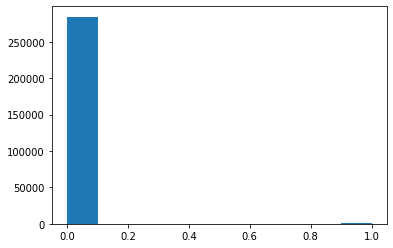

In [4]:
plt.hist(y)

As you can see the vast majority of transactions were not frauds. \
Now I am going to decide which are the most important variables to predict the outcome of a transaction using Recursive Feature Elimination.

In [8]:
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 20)
fit = rfe.fit(X, y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 20
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


I choosed the 20th most important variables. \
Next I will do an hyphotesis test to decide which variables are in fact important.

In [11]:
X=X.loc[:,fit.support_]
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.692071
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: -53.431    
Dependent Variable: Class            AIC:              394253.5782
Date:               2020-10-20 19:23 BIC:              394464.7696
No. Observations:   284807           Log-Likelihood:   -1.9711e+05
Df Model:           19               LL-Null:          -3621.2    
Df Residuals:       284787           LLR p-value:      1.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
V4         0.0179     0.0027     6.6750   0.0000    0.0126    0.0231
V5        -0.0139     0.0028    -4.9828   0.0

In [12]:
hyp = result.summary2().tables[1].iloc[:,3]<.05 #Hyphotesis proof
X = X.loc[:,hyp]

Now we got rid of the variables that did not pass the test. \
Next I used a logistic regression model which works perfectly for binary results.

In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.30)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Performance Metrics

In this part i will show you how was the model's perfomance.

In [14]:
y_pred = logreg.predict(X_test)
accuracy_score(y_test,y_pred)

0.9992158515033414

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.59      0.72       148

    accuracy                           1.00     85443
   macro avg       0.96      0.80      0.86     85443
weighted avg       1.00      1.00      1.00     85443



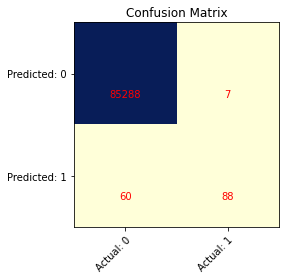

In [20]:
cm=confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm,cmap="YlGnBu")

ax.set_xticks(np.arange(np.size(cm,0)))
ax.set_yticks(np.arange(np.size(cm,1)))

ax.set_xticklabels(["Actual: 0","Actual: 1"])
ax.set_yticklabels(["Predicted: 0", "Predicted: 1"])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(cm)):
    for j in range(len(cm)):
            text = ax.text(j, i+.2, cm[i, j],
                       ha='center',va='center',color='red')

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

I graphed a ROC curve which determines the perfomance of the model. \
It tells us how much the model is capable of distinguishing classes. \
As you can see the model got an .8 out of 1 so it is good model to classify if the transactions will be frauds or not.

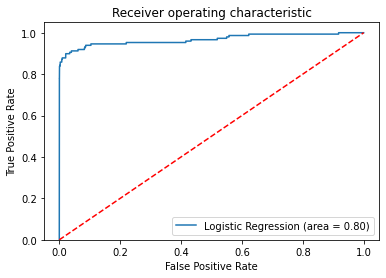

In [21]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()